In [4]:
# Cell 0: imports & load data + class weights
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# sklearn imports used across notebook
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    precision_recall_curve, roc_curve,
    confusion_matrix, classification_report
)

# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# imblearn for SMOTE (used later)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# File paths (adjust if your working dir differs)
DATA_PATH = "provider_features_final.csv"        # put csv in same folder or adjust path
CLASS_WEIGHTS_PATH = "../data/class_weights.json"       # put json in same folder or adjust path

# Load files
df = pd.read_csv(DATA_PATH, low_memory=False)
with open(CLASS_WEIGHTS_PATH, "r") as f:
    class_weight_map = json.load(f)

print("Loaded data shape:", df.shape)
print("Sample columns (repr):", [repr(c) for c in df.columns[:20]])
print("Loaded class_weights keys:", class_weight_map.keys())


Loaded data shape: (5410, 19)
Sample columns (repr): ["'Provider'", "'inpatient_claim_count'", "'in_sum_amt'", "'in_mean_amt'", "'in_std_amt'", "'in_unique_benes'", "'outpatient_claim_count'", "'out_sum_amt'", "'out_mean_amt'", "'out_std_amt'", "'out_unique_benes'", "'total_claim_count'", "'total_sum_amt'", "'mean_amt_overall'", "'pct_inpatient'", "'unique_beneficiaries'", "'PotentialFraud'", "'_label_raw'", "'_label'"]
Loaded class_weights keys: dict_keys(['0', '1'])


In [5]:
# Cell 1: clean label, drop leakage and IDs, create stratified train/test split
# Detect canonical label column (prefer _label)
candidates = ["_label", "label", "target", "fraud", "is_fraud"]
raw_label_col = None
for c in candidates:
    if c in df.columns:
        raw_label_col = c
        break
# fallback search if not found
if raw_label_col is None:
    found = [c for c in df.columns if any(tok in c.lower() for tok in ("label", "fraud", "potential"))]
    if found:
        raw_label_col = found[-1]
        print("Using candidate label column:", raw_label_col)
    else:
        raise RuntimeError("No label-like column found. Inspect df.columns manually.")

print("Raw distinct examples in label column:", pd.Series(df[raw_label_col].astype(str).str.strip().str.lower().unique()[:20]).tolist())

# Standard token map for common values
token_map = {
    "fraud":1, "fraudulent":1, "yes":1, "y":1, "true":1, "t":1, "1":1,
    "legit":0, "no":0, "n":0, "false":0, "0":0
}

mapped = df[raw_label_col].astype(str).str.strip().str.lower().map(token_map)
n_total = len(df)
n_mapped = mapped.notna().sum()
print(f"Auto-mapped {n_mapped}/{n_total} rows ({n_mapped/n_total:.2%})")

# If mapping doesn't cover most rows, but values are exactly 'legit'/'fraud', map explicitly.
unique_vals = set(df[raw_label_col].astype(str).str.strip().str.lower().unique())
if n_mapped / n_total < 0.95:
    if unique_vals <= {"legit", "fraud"}:
        df["_label"] = df[raw_label_col].astype(str).str.strip().str.lower().map({"legit":0, "fraud":1})
        print("Mapped explicit {'legit':0,'fraud':1} to _label.")
    else:
        # Show unmapped examples and raise so you can confirm mapping (prevents silent mistakes)
        unmapped = df[raw_label_col].astype(str).str.strip().str.lower()[mapped.isna()].value_counts().head(50)
        print("Too many unmapped label tokens. Examples (lowercased -> count):")
        print(unmapped.to_string())
        raise RuntimeError("Label tokens require manual mapping. Inspect examples above and update token_map.")
else:
    df["_label"] = mapped.astype(int)
    print("Mapping accepted into _label column.")

# Drop leakage columns that directly reveal label or are intermediate
leakage_cols = ["PotentialFraud", "_label_raw", "_labelraw", "_label_raw ", "Potential_Fraud"]
print("Dropping leakage columns from features if present:", leakage_cols)
df = df.drop(columns=[c for c in leakage_cols if c in df.columns], errors="ignore")

# Drop provider identifier columns (common patterns)
id_like = [c for c in df.columns if ("provider" in c.lower() or c.lower().endswith("id") or c.lower().endswith("_id")) and c != "_label"]
print("Dropping id-like columns:", id_like)
df = df.drop(columns=id_like, errors="ignore")

# Final X and y
if "_label" not in df.columns:
    raise RuntimeError("After mapping, '_label' not present. Check mapping logic.")
y = df["_label"].astype(int)
X = df.drop(columns=["_label"], errors="ignore")

print("Final X shape:", X.shape, " | y distribution:\n", y.value_counts())

# Stratified split (80/20 or change test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Positive fraction in train:", y_train.mean())


Raw distinct examples in label column: ['legit', 'fraud']
Auto-mapped 5410/5410 rows (100.00%)
Mapping accepted into _label column.
Dropping leakage columns from features if present: ['PotentialFraud', '_label_raw', '_labelraw', '_label_raw ', 'Potential_Fraud']
Dropping id-like columns: ['Provider']
Final X shape: (5410, 15)  | y distribution:
 _label
0    4904
1     506
Name: count, dtype: int64
Train shape: (4328, 15) Test shape: (1082, 15)
Positive fraction in train: 0.09357670979667283


In [6]:
# Cell 2: additional ID drop heuristics & build preprocessor
def drop_identifier_columns(df, id_threshold=0.9):
    drop_cols = []
    n = len(df)
    for col in df.columns:
        lowname = col.lower()
        uniq_frac = df[col].nunique(dropna=False) / max(1, n)
        if ("id" in lowname) or (uniq_frac > id_threshold):
            drop_cols.append(col)
    return drop_cols

# (This will catch any remaining high-cardinality columns not already removed)
id_cols = drop_identifier_columns(X_train, id_threshold=0.99)
# exclude known numeric features accidentally flagged (optional): adjust threshold as needed
print("Additional identifier-like columns to drop (if any):", id_cols)
X_train_clean = X_train.drop(columns=id_cols, errors='ignore').copy()
X_test_clean  = X_test.drop(columns=id_cols, errors='ignore').copy()

# detect numeric vs categorical
numeric_cols = X_train_clean.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = X_train_clean.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print("Numeric cols:", len(numeric_cols), numeric_cols[:10])
print("Categorical cols:", len(categorical_cols), categorical_cols[:10])

# transformers
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="__MISSING__")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, categorical_cols)
], remainder="drop", sparse_threshold=0)
print("Preprocessor ready.")


Additional identifier-like columns to drop (if any): []
Numeric cols: 15 ['inpatient_claim_count', 'in_sum_amt', 'in_mean_amt', 'in_std_amt', 'in_unique_benes', 'outpatient_claim_count', 'out_sum_amt', 'out_mean_amt', 'out_std_amt', 'out_unique_benes']
Categorical cols: 0 []
Preprocessor ready.


In [7]:
# Cell 3: normalize class_weight_map keys to match y dtype
def normalize_class_weight_map(class_weight_map, y_series):
    keys_as_int = {}
    for k, v in class_weight_map.items():
        try:
            ik = int(k)
        except Exception:
            ik = k
        keys_as_int[ik] = float(v)

    y_vals = np.unique(y_series.values)
    final_map = {}
    for k, v in keys_as_int.items():
        if k in y_vals:
            final_map[k] = v
        else:
            try:
                coerced = type(y_vals[0])(k)
                if coerced in y_vals:
                    final_map[coerced] = v
            except Exception:
                pass

    if not final_map and len(class_weight_map) == 2:
        vals = list(class_weight_map.values())
        final_map = {0: float(vals[0]), 1: float(vals[1])}

    return final_map

class_weight_map = normalize_class_weight_map(class_weight_map, y_train)
print("Normalized class_weight_map used:", class_weight_map)


Normalized class_weight_map used: {0: 0.5515905383360522, 1: 5.345849802371541}


In [8]:
def evaluate(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    pr_auc = average_precision_score(y_test, y_prob)

    print(f"\n=== {model_name} Performance ===")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")
    print(f"PR-AUC:    {pr_auc:.4f}")

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr)
    plt.title(f"ROC Curve — {model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

    # PR Curve
    p, r, _ = precision_recall_curve(y_test, y_prob)
    plt.plot(r, p)
    plt.title(f"Precision-Recall Curve — {model_name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()



=== Logistic Regression Performance ===
Precision: 0.3982
Recall:    0.8713
F1 Score:  0.5466
ROC-AUC:   0.9540
PR-AUC:    0.7502

Confusion Matrix:
[[848 133]
 [ 13  88]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.86      0.92       981
           1       0.40      0.87      0.55       101

    accuracy                           0.87      1082
   macro avg       0.69      0.87      0.73      1082
weighted avg       0.93      0.87      0.89      1082



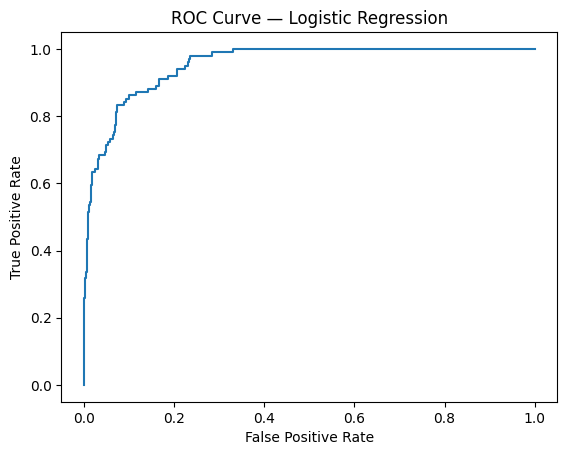


=== Logistic Regression Performance ===
Precision: 0.3982
Recall:    0.8713
F1 Score:  0.5466
ROC-AUC:   0.9540
PR-AUC:    0.7502

Confusion Matrix:
[[848 133]
 [ 13  88]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.86      0.92       981
           1       0.40      0.87      0.55       101

    accuracy                           0.87      1082
   macro avg       0.69      0.87      0.73      1082
weighted avg       0.93      0.87      0.89      1082



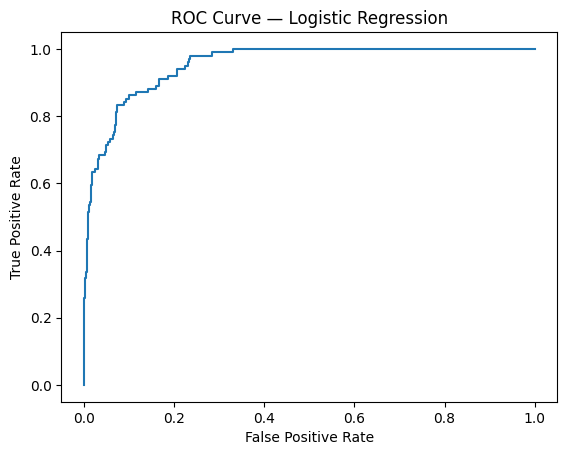

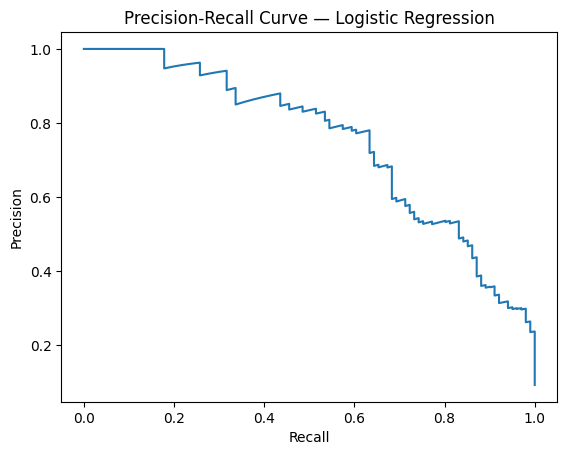

In [9]:
# Cell 5: Logistic Regression
log_reg = Pipeline([
    ("preproc", preprocessor),
    ("clf", LogisticRegression(class_weight=class_weight_map or "balanced", max_iter=3000, solver="saga"))
])

log_reg.fit(X_train_clean, y_train)
evaluate(log_reg, X_test_clean, y_test, "Logistic Regression")



=== Decision Tree Performance ===
Precision: 0.3937
Recall:    0.8614
F1 Score:  0.5404
ROC-AUC:   0.9043
PR-AUC:    0.6582

Confusion Matrix:
[[847 134]
 [ 14  87]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.86      0.92       981
           1       0.39      0.86      0.54       101

    accuracy                           0.86      1082
   macro avg       0.69      0.86      0.73      1082
weighted avg       0.93      0.86      0.88      1082



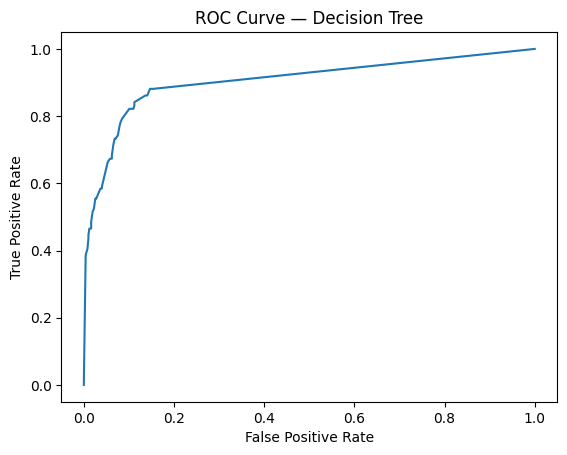


=== Decision Tree Performance ===
Precision: 0.3937
Recall:    0.8614
F1 Score:  0.5404
ROC-AUC:   0.9043
PR-AUC:    0.6582

Confusion Matrix:
[[847 134]
 [ 14  87]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.86      0.92       981
           1       0.39      0.86      0.54       101

    accuracy                           0.86      1082
   macro avg       0.69      0.86      0.73      1082
weighted avg       0.93      0.86      0.88      1082



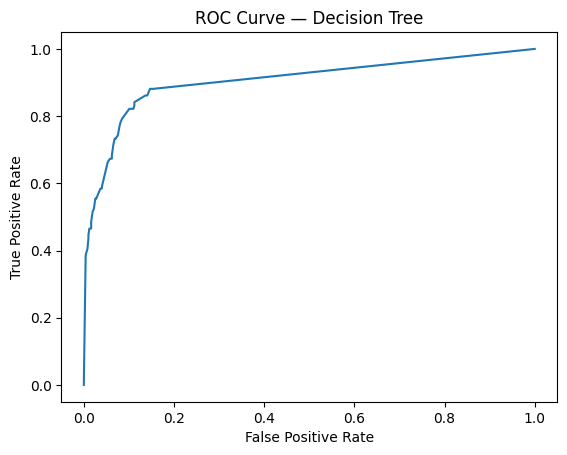

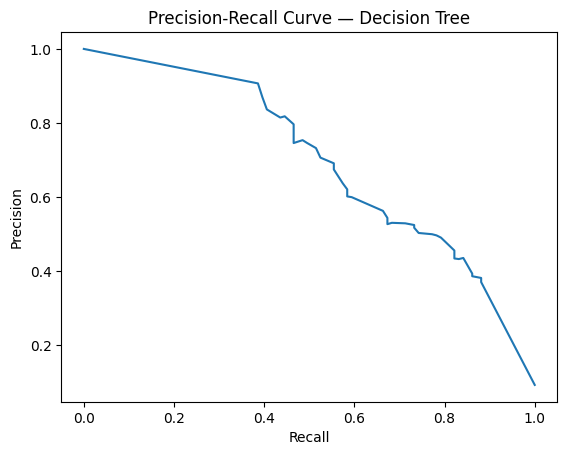

In [10]:
# Cell: Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

dt = Pipeline([
    ("preproc", preprocessor),
    ("clf", DecisionTreeClassifier(
        class_weight=class_weight_map or "balanced",
        random_state=42,
        max_depth=10,           # Limit depth to prevent overfitting
        min_samples_split=20,   # Require at least 20 samples to split
        min_samples_leaf=10     # Require at least 10 samples in leaf nodes
    ))
])

dt.fit(X_train_clean, y_train)
evaluate(dt, X_test_clean, y_test, "Decision Tree")


=== Random Forest Performance ===
Precision: 0.7333
Recall:    0.5446
F1 Score:  0.6250
ROC-AUC:   0.9452
PR-AUC:    0.7182

Confusion Matrix:
[[961  20]
 [ 46  55]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       981
           1       0.73      0.54      0.62       101

    accuracy                           0.94      1082
   macro avg       0.84      0.76      0.80      1082
weighted avg       0.93      0.94      0.93      1082



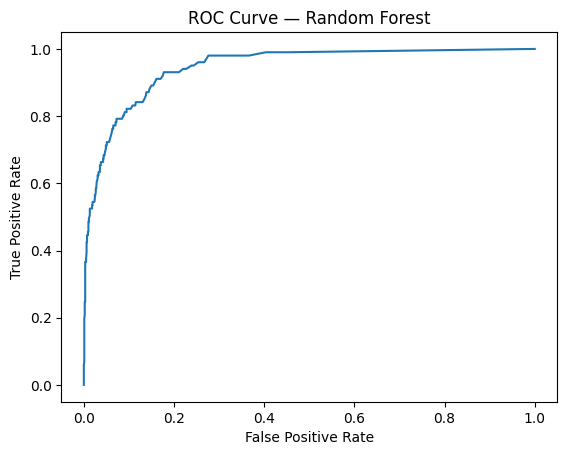


=== Random Forest Performance ===
Precision: 0.7333
Recall:    0.5446
F1 Score:  0.6250
ROC-AUC:   0.9452
PR-AUC:    0.7182

Confusion Matrix:
[[961  20]
 [ 46  55]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       981
           1       0.73      0.54      0.62       101

    accuracy                           0.94      1082
   macro avg       0.84      0.76      0.80      1082
weighted avg       0.93      0.94      0.93      1082



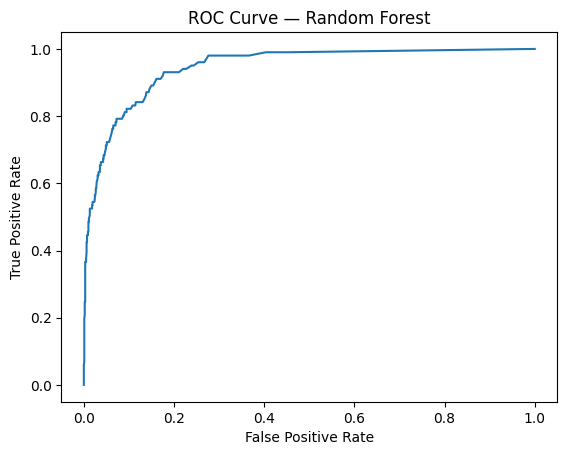

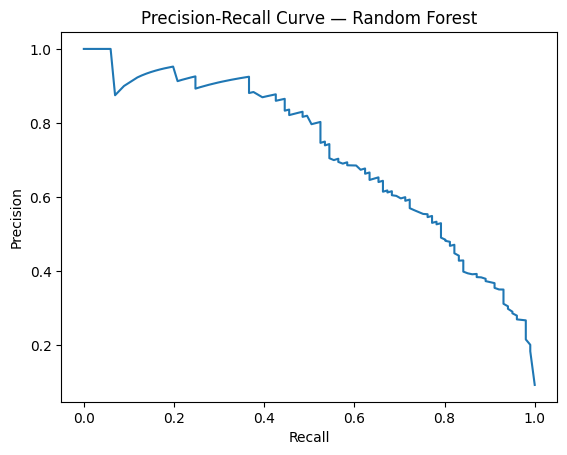

In [11]:
# Cell 6: Random Forest
rf = Pipeline([
    ("preproc", preprocessor),
    ("clf", RandomForestClassifier(n_estimators=300, class_weight=class_weight_map or "balanced", random_state=42, n_jobs=-1))
])

rf.fit(X_train_clean, y_train)
evaluate(rf, X_test_clean, y_test, "Random Forest")



=== SVM (RBF) Performance ===
Precision: 0.3704
Recall:    0.8911
F1 Score:  0.5233
ROC-AUC:   0.9315
PR-AUC:    0.5547

Confusion Matrix:
[[828 153]
 [ 11  90]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.84      0.91       981
           1       0.37      0.89      0.52       101

    accuracy                           0.85      1082
   macro avg       0.68      0.87      0.72      1082
weighted avg       0.93      0.85      0.87      1082



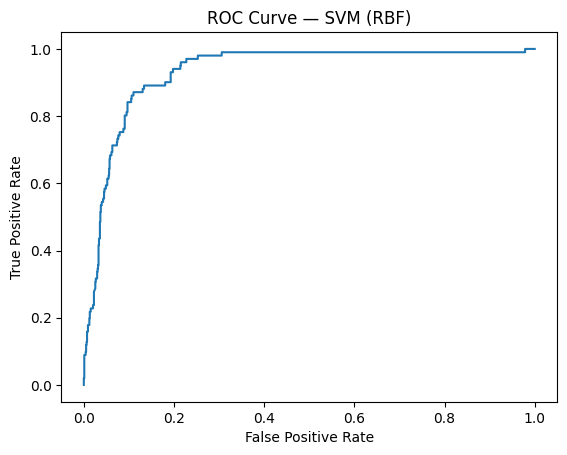


=== SVM (RBF) Performance ===
Precision: 0.3704
Recall:    0.8911
F1 Score:  0.5233
ROC-AUC:   0.9315
PR-AUC:    0.5547

Confusion Matrix:
[[828 153]
 [ 11  90]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.84      0.91       981
           1       0.37      0.89      0.52       101

    accuracy                           0.85      1082
   macro avg       0.68      0.87      0.72      1082
weighted avg       0.93      0.85      0.87      1082



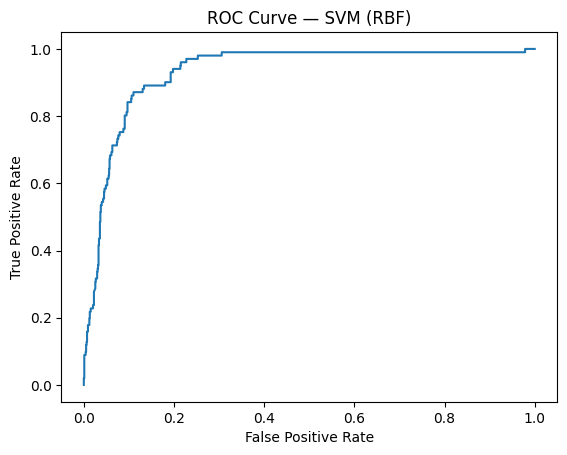

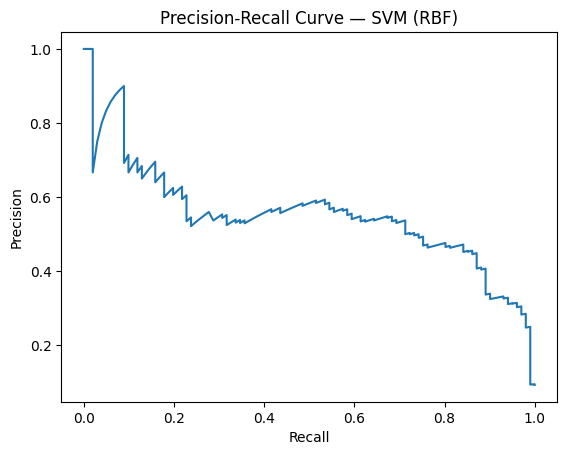

In [12]:
# Cell 7: SVM (SVC with probability estimates)
svm = Pipeline([
    ("preproc", preprocessor),
    ("clf", SVC(kernel="rbf", probability=True, class_weight=class_weight_map or "balanced", random_state=42))
])

# NOTE: SVM with many OHE features can be slow. If dataset is large, consider using a linear model or dimension reduction first.
svm.fit(X_train_clean, y_train)
evaluate(svm, X_test_clean, y_test, "SVM (RBF)")



=== Gradient Boosting (Baseline) Performance ===
Precision: 0.7051
Recall:    0.5446
F1 Score:  0.6145
ROC-AUC:   0.9531
PR-AUC:    0.7385

Confusion Matrix:
[[958  23]
 [ 46  55]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       981
           1       0.71      0.54      0.61       101

    accuracy                           0.94      1082
   macro avg       0.83      0.76      0.79      1082
weighted avg       0.93      0.94      0.93      1082



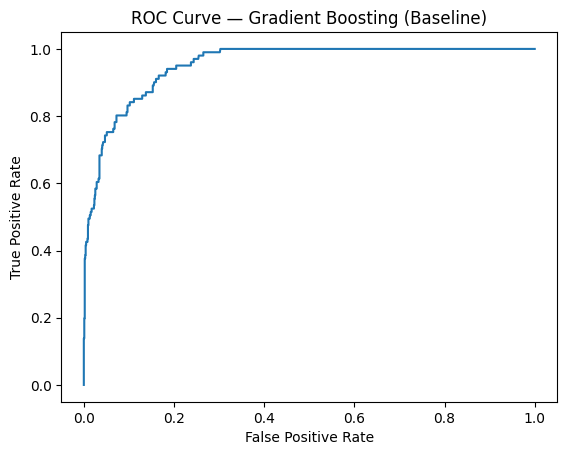

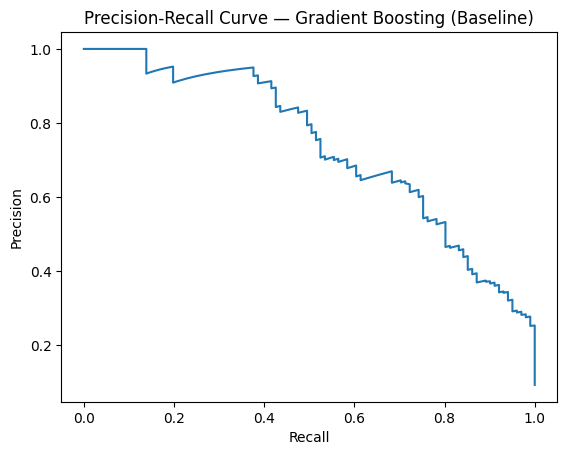

In [25]:
# Cell 8: Gradient Boosting (baseline)
gb_baseline = Pipeline([
    ("preproc", preprocessor),
    ("clf", GradientBoostingClassifier(random_state=42))
])

gb_baseline.fit(X_train_clean, y_train)
evaluate(gb_baseline, X_test_clean, y_test, "Gradient Boosting (Baseline)")


Sample weights example: [0.55159054 0.55159054 0.55159054 0.55159054 0.55159054 0.55159054
 0.55159054 0.55159054 0.55159054 0.55159054]

=== Gradient Boosting (Class-Weighted via sample_weight) Performance ===
Precision: 0.4229
Recall:    0.8416
F1 Score:  0.5629
ROC-AUC:   0.9530
PR-AUC:    0.7343

Confusion Matrix:
[[865 116]
 [ 16  85]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.88      0.93       981
           1       0.42      0.84      0.56       101

    accuracy                           0.88      1082
   macro avg       0.70      0.86      0.75      1082
weighted avg       0.93      0.88      0.89      1082



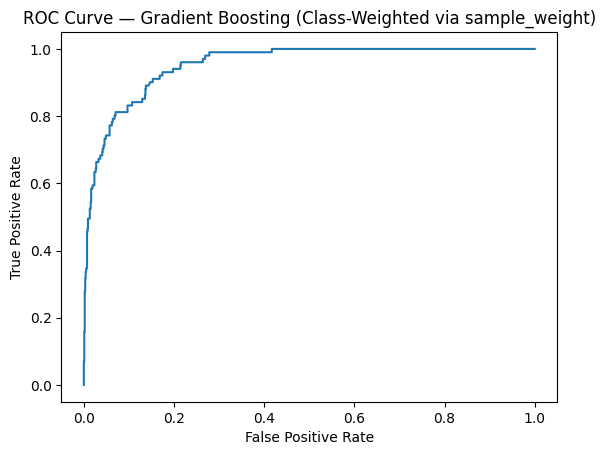

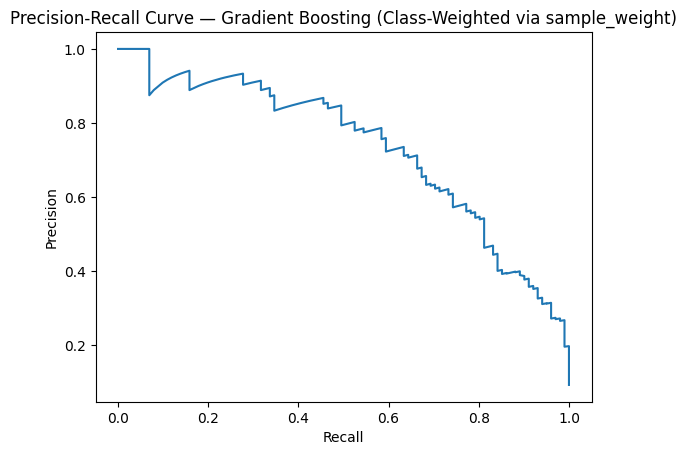

In [26]:
# Cell 9: Gradient Boosting with class-weight via sample_weight
# create sample weights aligned to y_train
# class_weight_map should map actual class labels (0/1) to weights
if not class_weight_map:
    # fallback to compute_class_weight
    from sklearn.utils.class_weight import compute_class_weight
    cw = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
    class_weight_map = {cls: w for cls, w in zip(np.unique(y_train), cw)}
    print("Computed fallback class_weight_map:", class_weight_map)

sample_weights = y_train.map(class_weight_map)
print("Sample weights example:", sample_weights.iloc[:10].values)

gb_weighted = Pipeline([
    ("preproc", preprocessor),
    ("clf", GradientBoostingClassifier(random_state=42))
])

# When using a sklearn Pipeline, pass sample_weight as fit param for the final estimator:
gb_weighted.fit(X_train_clean, y_train, clf__sample_weight=sample_weights)
evaluate(gb_weighted, X_test_clean, y_test, "Gradient Boosting (Class-Weighted via sample_weight)")



=== Gradient Boosting (SMOTE Oversampled) Performance ===
Precision: 0.4167
Recall:    0.8416
F1 Score:  0.5574
ROC-AUC:   0.9517
PR-AUC:    0.7259

Confusion Matrix:
[[862 119]
 [ 16  85]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.88      0.93       981
           1       0.42      0.84      0.56       101

    accuracy                           0.88      1082
   macro avg       0.70      0.86      0.74      1082
weighted avg       0.93      0.88      0.89      1082



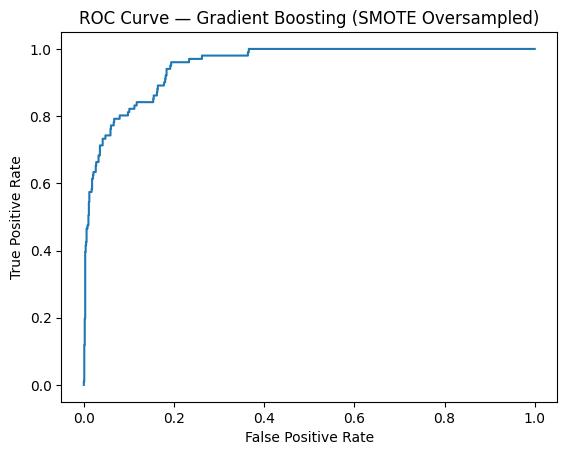

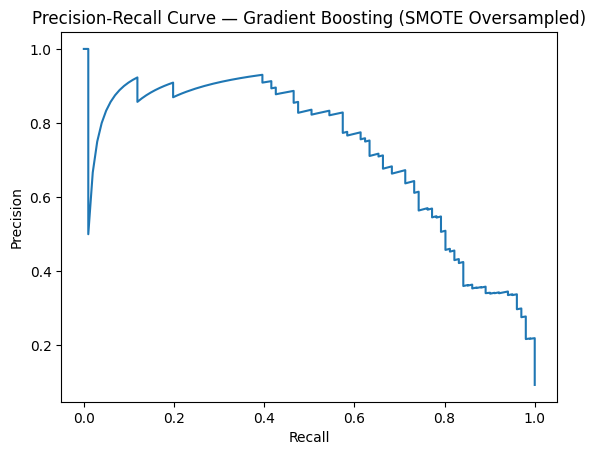

In [27]:
# Cell 10: Gradient Boosting with SMOTE oversampling
gb_smote = ImbPipeline([
    ("smote", SMOTE(random_state=42)),
    ("preproc", preprocessor),
    ("clf", GradientBoostingClassifier(random_state=42))
])

# This will oversample training set within the pipeline; DO NOT pass sample_weight here.
gb_smote.fit(X_train_clean, y_train)
evaluate(gb_smote, X_test_clean, y_test, "Gradient Boosting (SMOTE Oversampled)")


In [28]:
# Cell 11: cross-validation comparison for main models (use smaller n_splits for speed)
models = {
    "Logistic": log_reg,
    "RandomForest": rf,
    "SVM": svm,
    "GB_baseline": gb_baseline
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = []
for name, model in models.items():
    print("Running CV for", name)
    # cross_val_score uses estimator clone, but we need to use pipeline that contains preprocessor
    scores = cross_val_score(model, X_train_clean, y_train, scoring="average_precision", cv=cv, n_jobs=-1)
    cv_results.append((name, scores.mean(), scores.std()))
    print(f"{name} PR-AUC: mean={scores.mean():.4f} std={scores.std():.4f}")

import pandas as pd
cv_df = pd.DataFrame(cv_results, columns=["model","pr_auc_mean","pr_auc_std"]).sort_values("pr_auc_mean", ascending=False)
cv_df


Running CV for Logistic
Logistic PR-AUC: mean=0.6820 std=0.0247
Running CV for RandomForest
RandomForest PR-AUC: mean=0.6606 std=0.0247
Running CV for SVM
SVM PR-AUC: mean=0.5052 std=0.0256
Running CV for GB_baseline
GB_baseline PR-AUC: mean=0.6647 std=0.0282


,model,pr_auc_mean,pr_auc_std
0,Logistic,0.681981,0.024662
3,GB_baseline,0.664667,0.028217
1,RandomForest,0.660557,0.024664
2,SVM,0.505181,0.025632


In [29]:
# Cell 12: error analysis — choose final model to inspect
# pick a model you want to analyze, e.g., gb_smote or gb_weighted or rf, etc.
final_model = gb_smote  # change to the model you prefer

# Build errors DataFrame
X_test_err = X_test_clean.copy()
X_test_err["y_true"] = y_test.values
X_test_err["y_pred"] = final_model.predict(X_test_clean)
# probability column (safe)
try:
    X_test_err["prob"] = final_model.predict_proba(X_test_clean)[:,1]
except Exception:
    try:
        X_test_err["prob"] = final_model.decision_function(X_test_clean)
    except Exception:
        X_test_err["prob"] = X_test_err["y_pred"]

fp = X_test_err[(X_test_err["y_true"] == 0) & (X_test_err["y_pred"] == 1)].sort_values("prob", ascending=False)
fn = X_test_err[(X_test_err["y_true"] == 1) & (X_test_err["y_pred"] == 0)].sort_values("prob", ascending=True)

print("False Positives (top 3):")
display(fp.head(3))
print("False Negatives (top 3):")
display(fn.head(3))


False Positives (top 3):


,inpatient_claim_count,in_sum_amt,in_mean_amt,in_std_amt,in_unique_benes,outpatient_claim_count,out_sum_amt,out_mean_amt,out_std_amt,out_unique_benes,total_claim_count,total_sum_amt,mean_amt_overall,pct_inpatient,unique_beneficiaries,y_true,y_pred,prob
3932,115.0,1308500.0,11378.260870,11236.904914,95.0,12.0,2540.0,211.666667,307.773037,12.0,127.0,1311040.0,10323.149606,0.905512,107.0,0,1,0.988037
361,112.0,1036690.0,9256.160714,10599.353562,103.0,23.0,2300.0,100.000000,115.443808,21.0,135.0,1038990.0,7696.222222,0.829630,124.0,0,1,0.983812
2167,71.0,868000.0,12225.352113,12979.321117,62.0,43.0,11270.0,262.093023,451.977444,42.0,114.0,879270.0,7712.894737,0.622807,104.0,0,1,0.978821


False Negatives (top 3):


,inpatient_claim_count,in_sum_amt,in_mean_amt,in_std_amt,in_unique_benes,outpatient_claim_count,out_sum_amt,out_mean_amt,out_std_amt,out_unique_benes,total_claim_count,total_sum_amt,mean_amt_overall,pct_inpatient,unique_beneficiaries,y_true,y_pred,prob
5324,3.0,20000.0,6666.666667,6350.852961,2.0,0.0,0.0,0.000000,0.000000,0.0,3.0,20000.0,6666.666667,1.000000,2.0,1,0,0.078582
3096,3.0,58000.0,19333.333333,15373.136743,3.0,0.0,0.0,0.000000,0.000000,0.0,3.0,58000.0,19333.333333,1.000000,3.0,1,0,0.078833
5248,5.0,31000.0,6200.000000,3033.150178,4.0,68.0,26940.0,396.176471,708.146686,58.0,73.0,57940.0,793.698630,0.068493,62.0,1,0,0.162273
